In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabuary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i +1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# split into training, dev/validation, test split to avoid over fitting and under fitting
# 80%, 10% 10% 

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [7]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [97]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproductivity
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / ((n_embd * block_size) ** 0.5))
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch normalization parameters
  
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b2, W1, b2, bngain, bnbias]

In [98]:
# number of parameters in total
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12724


In [10]:
Xtr.shape[0]

182625

In [17]:
# lri = []
# lossi = []
# stepi = []

In [99]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # hidden layer preactivation

    # batch norm layers
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact =  bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact) # hidden layer | activation function
    logits = h @ W2 + b2 # output layer
    # =========== DEPRECATED
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # =========== DEPRECATED
    loss = F.cross_entropy(logits, Yb) # loss function
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

# track stats
    if i % 10000 == 0: # modulo to print on every 10k steps along the way
        print(f'{i: 7d}/{max_steps: 7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.8586
  10000/ 200000:  2.5431
  20000/ 200000:  2.0232
  30000/ 200000:  2.1122
  40000/ 200000:  2.0482
  50000/ 200000:  1.9903
  60000/ 200000:  2.4981
  70000/ 200000:  2.1466
  80000/ 200000:  2.0043
  90000/ 200000:  2.4457
 100000/ 200000:  2.1429
 110000/ 200000:  2.2719
 120000/ 200000:  2.4500
 130000/ 200000:  1.5796
 140000/ 200000:  1.6982
 150000/ 200000:  2.4611
 160000/ 200000:  1.9638
 170000/ 200000:  1.9209
 180000/ 200000:  2.3502
 190000/ 200000:  1.6446


In [64]:
# plt.hist(h.view(-1).tolist(), 30)
# tanh saturation test

In [65]:
# plt.hist(hpreact.view(-1).tolist(), 30)
# tanh saturation test

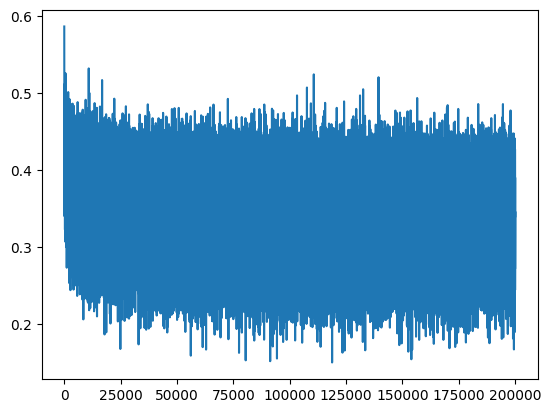

In [103]:
plt.plot(lossi)
# softmax confidence test

In [104]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # measure the mean/std over the entire training set
    # batch normalization
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


# hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape
# bnmean

tensor([[-0.1125, -0.6962, -2.0155, -1.6493,  1.1638, -0.9438,  1.1343, -0.7710,
         -0.4384,  1.3693, -1.4693, -1.2758, -0.1773,  0.4073, -1.9792, -2.8481,
          0.9616, -3.4606, -1.2726,  0.9510, -0.4775, -0.7564,  2.7180, -1.4240,
          0.8727,  0.3750,  1.7687,  0.0206, -0.3429,  1.0482,  1.4027, -1.4955,
         -0.3247,  0.3733, -0.3170,  1.3154, -1.3531,  1.3565,  0.5287,  0.2963,
         -0.5595, -2.7455, -0.6867,  0.3094,  0.1018, -0.8616,  0.4704,  0.4426,
          2.2613,  2.1967,  2.3273,  2.0339,  1.5013,  0.8986,  2.5703, -1.2231,
         -2.7829, -0.0762,  2.1839, -1.5872, -0.0554,  0.9998,  0.5907, -0.3457,
          0.9557, -0.8833, -1.0971,  0.9089,  0.5718,  0.4417, -0.2203, -1.3472,
          2.3177, -1.7209, -2.1883, -0.4721, -0.0098, -0.0839, -0.1666, -1.6761,
          2.3797, -1.6524,  0.0091,  1.0919,  2.2575, -0.1645,  0.5653,  1.6241,
         -0.0269,  0.2027,  0.3282,  0.0047, -0.1058, -1.2224, -0.7834,  0.9282,
          0.4826,  1.1285, -

In [107]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_Size * n_ebmd)
    hpreact = embcat @ W1  #+ b1 # hidden layer preactivation
    hpreact =  bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.133599281311035
val 2.158169984817505


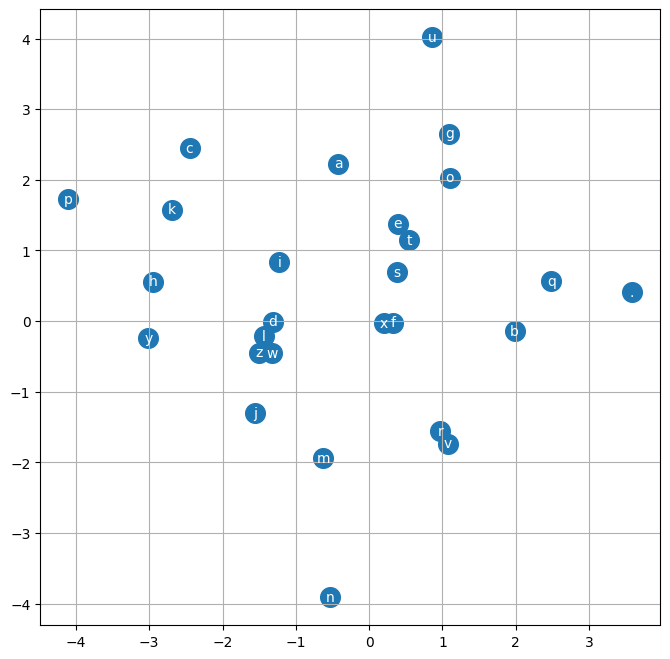

In [71]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [26]:
# sample from the network
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montalmyazhiee.
mad.
ryah.
rethruttadrari.
aderedielin.
shi.
jenleigh.
edora.
raelyn.
malke.
cayshaberghai.
jest.
jair.
jelionntton.
kue.
kavdi.
jamelizek.
yule.
mystouda.
halina.


In [ ]:
# let us infer a minibatch to save the NN from taking on too much at a time

torch.randint(0, X.shape[0], (32,)).shape

torch.Size([32])

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([1.5988, 4.2595, 2.1688, 2.0830, 2.2983, 1.9719, 1.5988, 1.7469, 2.0649,
        1.7365, 2.1566, 1.6348, 2.9471, 1.9044, 3.0296, 1.8141, 1.7365, 1.5003,
        1.9932, 2.2448, 2.0914, 2.3320, 2.2010, 1.9666, 2.6070, 2.1784, 2.0046,
        2.1909, 1.7365, 1.7365, 1.8599, 1.6266], grad_fn=<MaxBackward0>),
indices=tensor([12, 12,  1,  5,  0,  5, 12,  0,  1,  1,  0, 12,  0,  1,  5,  0,  1, 12,
         5,  0,  0,  5,  0,  5,  0,  5,  1,  1,  1,  1,  0,  5]))

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])